In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Learning Nash Equilibria

## References:

- [Multi-agent Q-learning and Nash equilibria](http://www.lirmm.fr/~jq/Cours/3cycle/module/HuWellman98icml.pdf)
- [Multi-agent RL for Stochastic Games](http://www.cs.toronto.edu/~gehalk/DepthReport/DepthReport.ps)

## Setting up games 

In [2]:
# 2-players game
n_actions = 2
n_players = 2

def init_payoffs(n_players, n_actions):
    payoff = np.ones([n_actions]*n_players+[n_players])
    return payoff

payoff = init_payoffs(n_players, n_actions)
payoff[0, 1, :] = 0
payoff[1, 0, :] = 0

def init_strategies(payoff):
    n_players = get_n_players(payoff)
    n_actions = get_n_actions(payoff)
    strategies = np.random.uniform(size=(n_players, n_actions)).T
    strategies_exp = np.exp(strategies)
    
    return (strategies_exp/strategies_exp.sum(axis=0)).T

def get_n_players(payoff):
    return payoff.shape[-1]

def get_n_actions(payoff):
    return payoff.shape[0]

In [3]:
strategies = init_strategies(payoff)

In [4]:
payoff

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

In [5]:
strategies

array([[0.38352525, 0.61647475],
       [0.6411225 , 0.3588775 ]])

In [6]:
# sanity check
strategies.sum(axis=1)

array([1., 1.])

In [7]:
def play_mixing(strategies, payoff, rounds=1):
    """
    Plays the given rounds using the strategy and calculates the payoff.
    """    
    n_players = get_n_players(payoff)
    actions = np.arange(get_n_actions(payoff))
    
    # init plays
    plays = np.empty((n_players, rounds), dtype=np.int32)
    
    # sample actions
    for i in range(n_players):
        plays[i, :] = np.random.choice(actions, 
                                       size=(rounds, ), 
                                       p=strategies[i])
    
    # calculate payout
    idx = tuple([plays[i] for i in range(n_players)]+[slice(None)])
    payouts = payoff[idx].T 
    
    return plays, payouts

plays, payouts = play_mixing(strategies, payoff, rounds=5)

In [8]:
plays

array([[1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0]], dtype=int32)

In [9]:
payouts

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [10]:
payouts.sum(axis=1)

array([1., 1.])

## Exploring the strategy-payoff surface

Lets see how different mixing strategies give payoff to the different players. We look at various two-person two-action games and visualize the payoff for both Player 1 and 2 for grid of possible mixing strategies. The horizontal axis is the probability of Player 1 playing their Action 1, the vertical axis is the probability of Player 2 playing their Action 1.

In [11]:
def explore_mixing(payoff, rounds = 1000):
    probs = np.linspace(0, 1, 21)
    p1_grid, p2_grid = np.meshgrid(probs, probs)
    payoff_grid = np.empty((2, p1_grid.shape[0], p1_grid.shape[1]))

    for i in range(p1_grid.shape[0]):
        for j in range(p1_grid.shape[1]):
            p1 = p1_grid[i, j]
            p2 = p2_grid[i, j]
            strategy = np.array([[p1, 1-p1], [p2, 1-p2]])
            plays, payouts = play_mixing(strategy, payoff, rounds=rounds)
            payoff_grid[:, i, j] = payouts.mean(axis=1)
    
    return p1_grid, p2_grid, payoff_grid

In [22]:
def plot_payoffs(p1_grid, p2_grid, payoff_grid):
    vmin, vmax = payoff_grid.min(), payoff_grid.max()

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    plt.subplot(1, 3, 1)
    cp = plt.contourf(p1_grid, p2_grid, payoff_grid[0], cmap="coolwarm", vmin=vmin, vmax=vmax)
    plt.title("Player 1 payout")
    plt.xlabel("Action 2 <--- Player 1 ---> Action 1")
    plt.ylabel("Action 2 <--- Player 2 ---> Action 1")
    #fig.colorbar(cp)

    plt.subplot(1, 3, 2)
    cp = plt.contourf(p1_grid, p2_grid, payoff_grid[1], cmap="coolwarm", vmin=vmin, vmax=vmax)
    plt.title("Player 2 payout")
    plt.xlabel("Action 2 <--- Player 1 ---> Action 1")
    plt.ylabel("Action 2 <--- Player 2 ---> Action 1")
    #fig.colorbar(cp) 
    
    plt.subplot(1, 3, 3)
    cp = plt.contourf(p1_grid, p2_grid, payoff_grid.mean(axis=0), cmap="coolwarm", vmin=vmin, vmax=vmax)
    plt.title("Mean payout")
    plt.xlabel("Action 2 <--- Player 1 ---> Action 1")
    plt.ylabel("Action 2 <--- Player 2 ---> Action 1")
    fig.colorbar(cp) 

    return fig

### Guess-the-same

The players get the same payoff in case they pick the same action, no payoff otherwise.

In [23]:
payoff = np.array([[[1, 1], [0, 0]], 
                   [[0, 0], [1, 1]]])

PAYOFFS = dict()
PAYOFFS["Guess-the-same"] = payoff.copy()

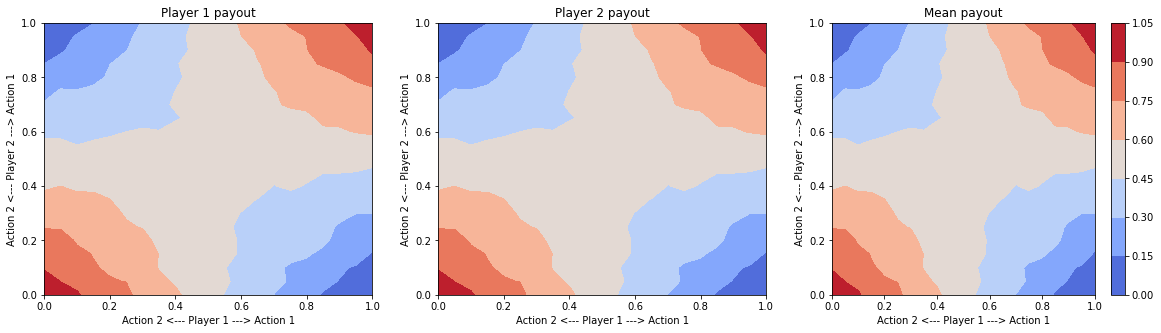

In [24]:
p1_grid, p2_grid, payoff_grid = explore_mixing(payoff)
fig = plot_payoffs(p1_grid, p2_grid, payoff_grid)
plt.show()

### Matching Pennies

Player 1 wins if their choice of actions match, Player 2 wins if their choice of actions mismatch.

In [25]:
payoff = np.array([[[1, -1], [-1, 1]], 
                   [[-1, 1], [1, -1]]])
PAYOFFS["Matching pennies"] = payoff.copy()

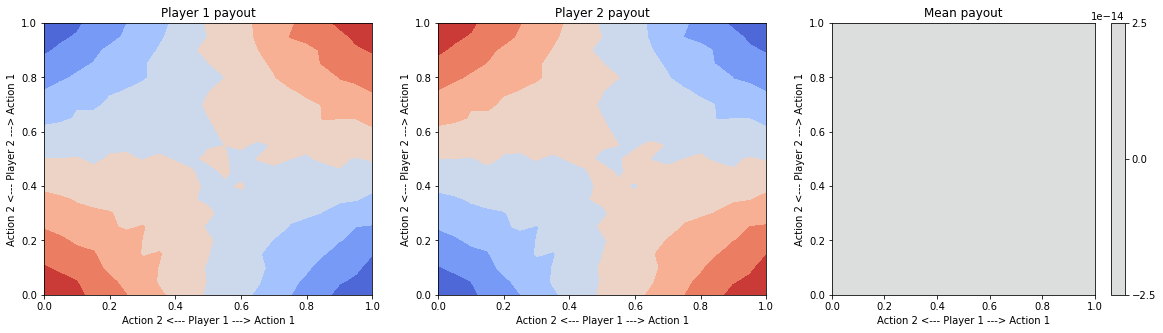

In [26]:
p1_grid, p2_grid, payoff_grid = explore_mixing(payoff)
fig = plot_payoffs(p1_grid, p2_grid, payoff_grid)
plt.show()

We can change the payoff structure to make one of the outcomes more sensitive.

In [27]:
payoff = np.array([[[1, -1], [-1, 1]], 
                   [[-2, 2], [1, -1]]])

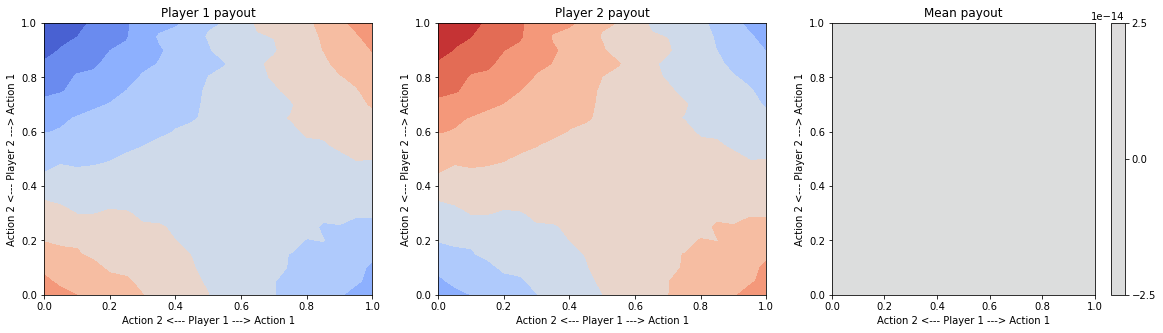

In [28]:
p1_grid, p2_grid, payoff_grid = explore_mixing(payoff)
fig = plot_payoffs(p1_grid, p2_grid, payoff_grid)
plt.show()

It is quite apparent from the third plot that Matching Pennies is a zero-sum game.

### Prisoner's Dilemma

The players can choose to confess or defect their crime.
- Action 1: defect
- Action 2: confess

In [29]:
payoff = np.array([[[-2, -2], [0, -10]], 
                   [[-10, 0], [-5, -5]]])
PAYOFFS["Prisoner's dilemma"] = payoff.copy()

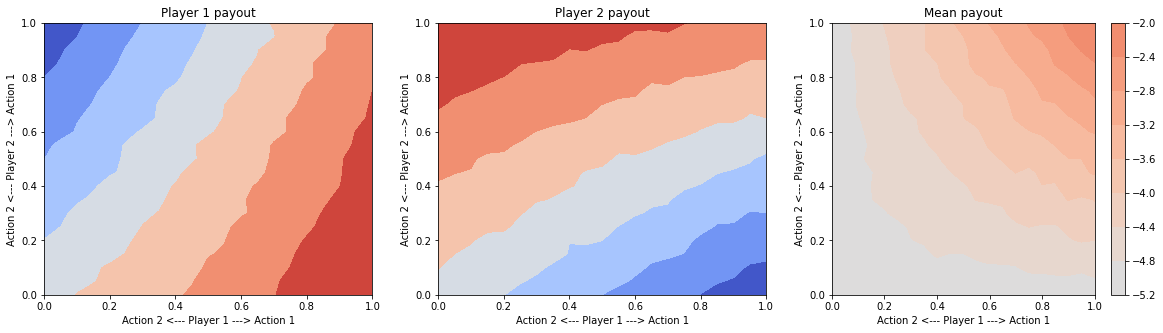

In [30]:
p1_grid, p2_grid, payoff_grid = explore_mixing(payoff)
fig = plot_payoffs(p1_grid, p2_grid, payoff_grid)
plt.show()

### Hares and Stags

- Action 1: go for hares
- Action 2: go for stags

In [31]:
payoff = np.array([[[3, 3], [3, 0]], 
                   [[0, 3], [6, 6]]])
PAYOFFS["Hares and stags"] = payoff.copy()

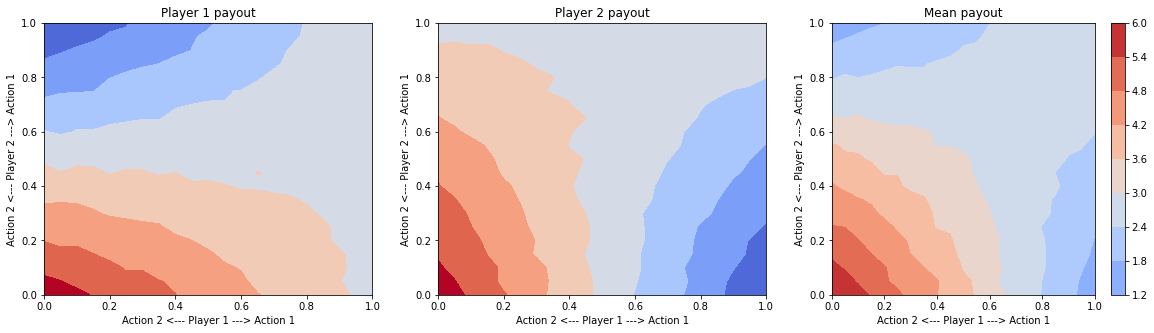

In [32]:
p1_grid, p2_grid, payoff_grid = explore_mixing(payoff)
fig = plot_payoffs(p1_grid, p2_grid, payoff_grid)
plt.show()

## Optimizing the strategy for 2-player, 2-strategy games 

In [33]:
from torch import nn
from torch.optim import SGD
import torch

### Gradient descent for the best mixing probabilities 

Plan for policy learning using gradient descent:
1. initialize random strategies
2. iterate until some convergence criteria is met:
    - play N number of games
    - calculate the loss as negative average payout
    - optimization step

In [34]:
class Model(nn.Module):
    def __init__(self, payoff, mixing_probabilities):
        '''
        payoff: shape 2x2x2
        mixing_probabilities: shape 2
        '''
        super().__init__()
        self.payoff = torch.tensor(payoff)
        self.mixing_probabilities = torch.tensor(mixing_probabilities, dtype=torch.float32, requires_grad=True)
        
    def get_strategies(self):
        return torch.stack([self.mixing_probabilities, 1-self.mixing_probabilities], dim=1)
        
    def negative_payout(self, plays):
        '''
        Base on the plays of P2 and P1's strategy, calculate the expected payout for P1 and vice versa.
        '''
        
        plays = torch.tensor(plays).long()
        strategies = self.get_strategies() # dim 2 x 2
        
        p1_strategy = strategies[0].unsqueeze(1) # dim 2 x 1     
        p1_payouts = self.payoff[:, plays[1], 0] # dim 2 x 10
        p1_exp_payouts = (p1_payouts*p1_strategy).sum(axis=0) # dim 10
        p1_mean_payout = p1_exp_payouts.mean()                
        
        p2_strategy = strategies[1].unsqueeze(1)      
        p2_payouts = self.payoff[plays[0], :, 1].T
        p2_exp_payout = (p2_payouts*p2_strategy).sum(axis=0)
        p2_mean_payout = p2_exp_payout.mean()   
        
        return -(p1_mean_payout+p2_mean_payout)


We set up the mode with the payoff and the optimizer:

In [35]:
payoff = PAYOFFS["Hares and stags"]
payoff

array([[[3, 3],
        [3, 0]],

       [[0, 3],
        [6, 6]]])

In [49]:
model = Model(payoff, [0.1, 0.9])
optimizer = SGD([model.mixing_probabilities], lr=0.001, momentum=0.9)

The strategy is initialized with some random values:

In [50]:
model.get_strategies()

tensor([[0.1000, 0.9000],
        [0.9000, 0.1000]], grad_fn=<StackBackward>)

We play a few games with the current strategy:

In [51]:
strategies = model.get_strategies().detach().numpy()
plays, _ = play_mixing(strategies, payoff, rounds=100)

The total mean negative payout for the two players:

In [52]:
neg_payout = model.negative_payout(plays)
neg_payout

tensor(-4.1280, grad_fn=<NegBackward>)

Now we can calculate the gradient based on this:

In [53]:
neg_payout.backward()

In [54]:
model.mixing_probabilities.grad

tensor([-2.3400,  2.3400])

Let's apply the optimizer to lower the neg mean payout (i.e., to increase the mean payouts):

In [55]:
optimizer.step()

In [56]:
model.mixing_probabilities

tensor([0.1023, 0.8977], requires_grad=True)

The gradient step won't preserve that the strategies should sum to 1 so we need to fix this but exclude it from future gradient calculations.

In [57]:
model.mixing_probabilities.data.clamp_(min=0, max=1)

tensor([0.1023, 0.8977])

In [58]:
model.mixing_probabilities

tensor([0.1023, 0.8977], requires_grad=True)

In [60]:
optimizer.zero_grad()

Now lets run these steps interatively and see how the strategy evolves:

Lets wrap all of this into a function:

In [61]:
def optimize(payoff,
             initial_mixing_probs,
             lr=0.01,
             momentum=0.9,
             num_updates=100, 
             rounds_per_update=10):
    
    model = Model(payoff, initial_mixing_probs)
    optimizer = SGD([model.mixing_probabilities], lr=0.01, momentum=0.9)

    neg_payouts = np.empty(num_updates)
    learned_strategies = np.empty((2, num_updates))

    for i in range(num_updates):
        learned_strategies[:, i] = model.mixing_probabilities.detach().numpy()

        # play the game and calculate the payout
        strategies = model.get_strategies().detach().numpy()
        plays, _ = play_mixing(strategies, payoff, rounds=rounds_per_update)
        neg_payout = model.negative_payout(plays)

        # gradient step
        neg_payout.backward()
        optimizer.step()
        optimizer.zero_grad()

        # normalize probabilities and get new strategy
        model.mixing_probabilities.data.clamp_(min=0, max=1)

        neg_payouts[i] = neg_payout.detach()
        
    return neg_payouts, learned_strategies

In [71]:
payoff = PAYOFFS["Hares and stags"]
initial_mixing_probs = [0.1, 0.9]

neg_payouts, learned_strategies = optimize(payoff, initial_mixing_probs)

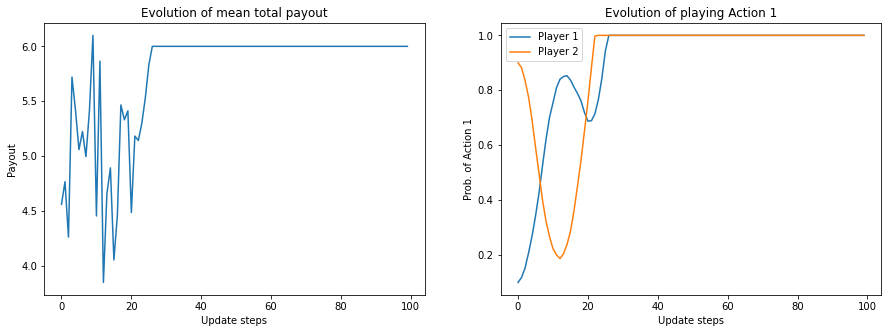

In [72]:
num_updates = 100
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_updates), -neg_payouts)
plt.xlabel("Update steps")
plt.ylabel("Payout")
plt.title("Evolution of mean total payout")

plt.subplot(1, 2, 2)
plt.plot(range(num_updates), learned_strategies[0, :], label="Player 1")
plt.plot(range(num_updates), learned_strategies[1, :], label="Player 2")
plt.title("Evolution of playing Action 1")
plt.xlabel("Update steps")
plt.ylabel("Prob. of Action 1")
plt.legend()
#plt.savefig("assets/hares_training_stats_3.png")
plt.show()

/home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:10: Matplotl

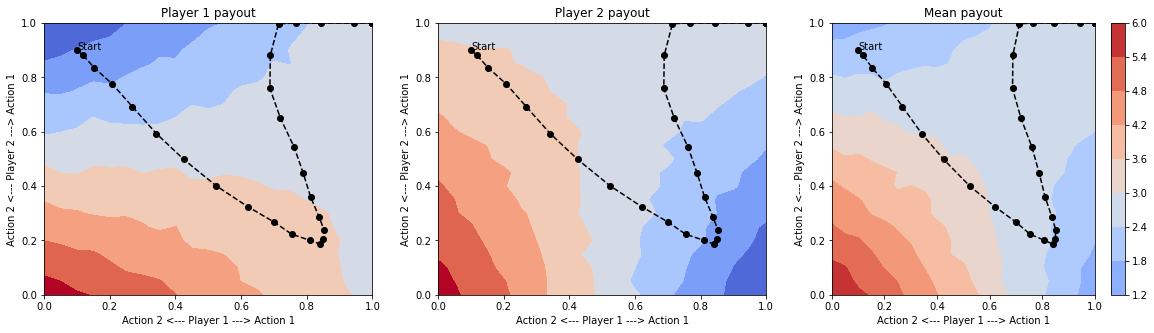

In [73]:
p1_grid, p2_grid, payoff_grid = explore_mixing(payoff)

fig = plot_payoffs(p1_grid, p2_grid, payoff_grid)
plt.subplot(1, 3, 1)
plt.text(learned_strategies[0, 0], learned_strategies[1, 0], "Start")
plt.plot(learned_strategies[0], learned_strategies[1], marker="o", linestyle="--", color="black")
plt.subplot(1, 3, 2)
plt.text(learned_strategies[0, 0], learned_strategies[1, 0], "Start")
plt.plot(learned_strategies[0], learned_strategies[1], marker="o", linestyle="--", color="black")
plt.subplot(1, 3, 3)
plt.text(learned_strategies[0, 0], learned_strategies[1, 0], "Start")
plt.plot(learned_strategies[0], learned_strategies[1], marker="o", linestyle="--", color="black")
#plt.savefig("assets/hares_opt_3.png")
plt.show()

There is a fair amount of variance in the results so we'll run a number of optimizations and see how the results vary.

In [79]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def run_experiment(payoff, 
                   initial_mixing_probs, 
                   num_updates=100,
                   num_runs=20,
                  game_name="unknown"):
    
    # run optimization
    results = pd.DataFrame()
    for i in range(num_runs):
        neg_payouts, learned_strategies = optimize(payoff, 
                                                   initial_mixing_probs, 
                                                   num_updates=num_updates)

        current_results = pd.DataFrame(data={"update_step": np.arange(num_updates),
                                             "run": np.full(num_updates, i),
                                            "payouts": -neg_payouts,
                                            "p1_mixing_prob": learned_strategies[0, :],
                                            "p2_mixing_prob": learned_strategies[1, :]})

        results = pd.concat([results, current_results], axis=0)

    # plot 
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x="update_step", y="payouts", data=results)
    plt.xlabel("Update steps")
    plt.ylabel("Payout")
    plt.title("Evolution of mean total payout")

    plt.subplot(1, 2, 2)
    sns.lineplot(x="update_step", y="p1_mixing_prob", data=results, label="Player 1")
    sns.lineplot(x="update_step", y="p1_mixing_prob", data=results, label="Player 2")
    plt.title("Evolution of playing Action 1")
    plt.xlabel("Update steps")
    plt.ylabel("Prob. of Action 1")
    plt.legend()
    plt.savefig(f"assets/stats_{game_name}_{initial_mixing_probs}.png")
    plt.show()
    
    p1_grid, p2_grid, payoff_grid = explore_mixing(payoff)
    fig = plot_payoffs(p1_grid, p2_grid, payoff_grid)
    for i in results["run"].unique():
        learned_strategies = results.loc[results.run == i, ["p1_mixing_prob", "p2_mixing_prob"]].values.T
        for subplot_idx in range(3):
            plt.subplot(1, 3, subplot_idx+1)
            if i==0:
                plt.text(learned_strategies[0, 0], learned_strategies[1, 0], "Start")
            plt.plot(learned_strategies[0], learned_strategies[1], linestyle="--", color="black", alpha=0.3)
      
    plt.savefig(f"assets/opt_{game_name}_{initial_mixing_probs}.png")
    plt.show()

## Hares and stags 

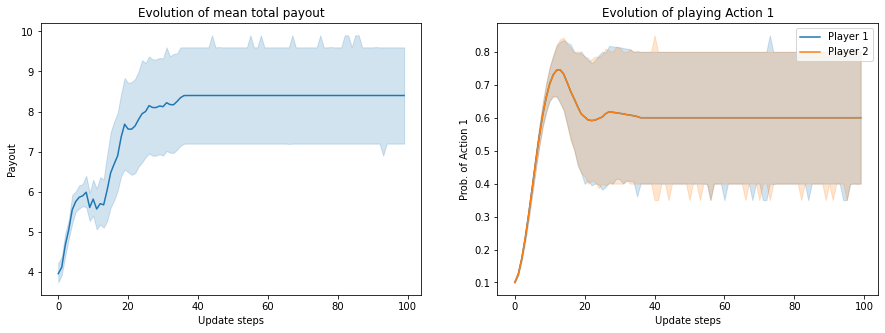

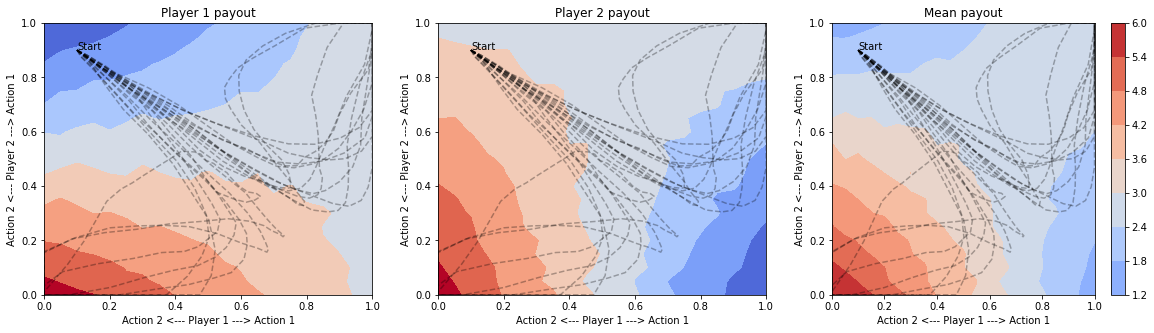

In [80]:
game_name = "Hares and stags"

run_experiment(PAYOFFS[game_name], 
                [0.1, 0.9], 
                num_updates=100,
                num_runs=20,
                game_name=game_name)

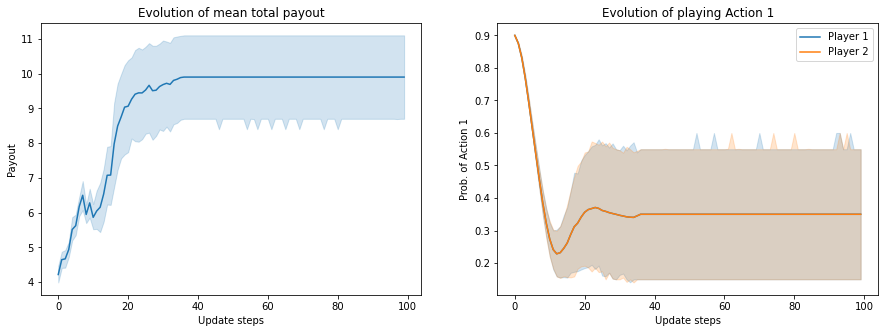

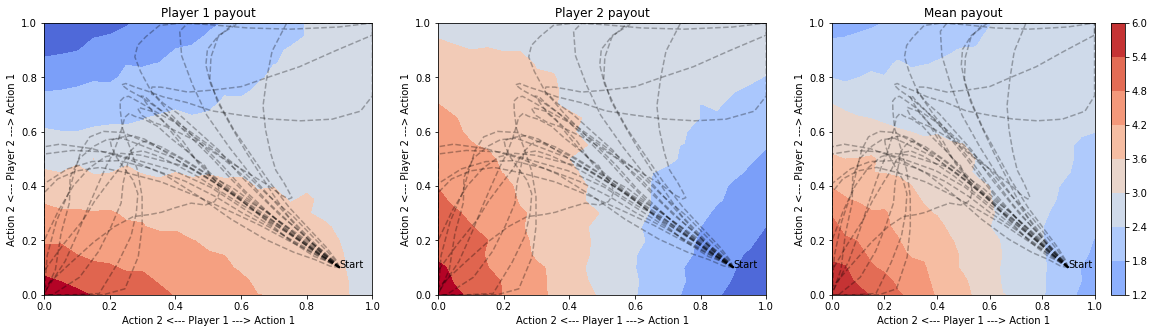

In [81]:
game_name = "Hares and stags"

run_experiment(PAYOFFS[game_name], 
                [0.9, 0.1], 
                num_updates=100,
                num_runs=20,
                game_name=game_name)

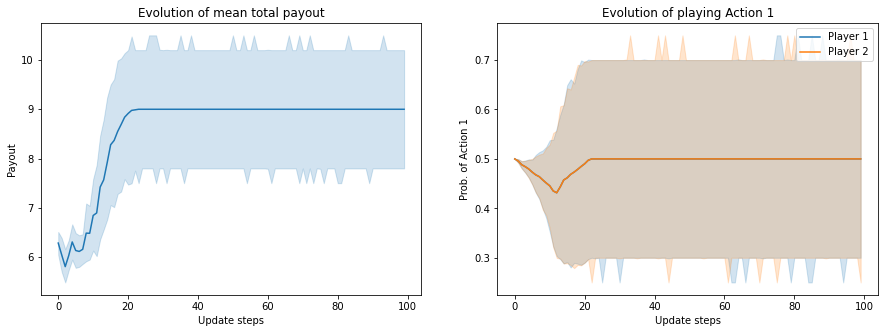

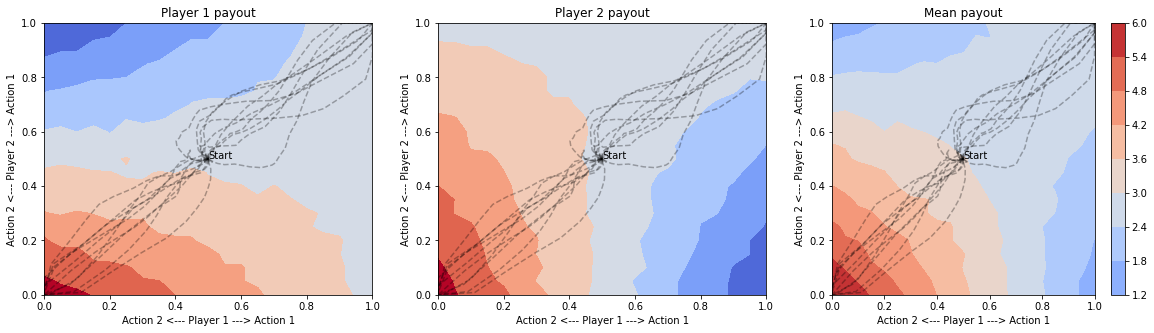

In [82]:
game_name = "Hares and stags"

run_experiment(PAYOFFS[game_name], 
                [0.5, 0.5], 
                num_updates=100,
                num_runs=20,
                game_name=game_name)

## Matching pennies

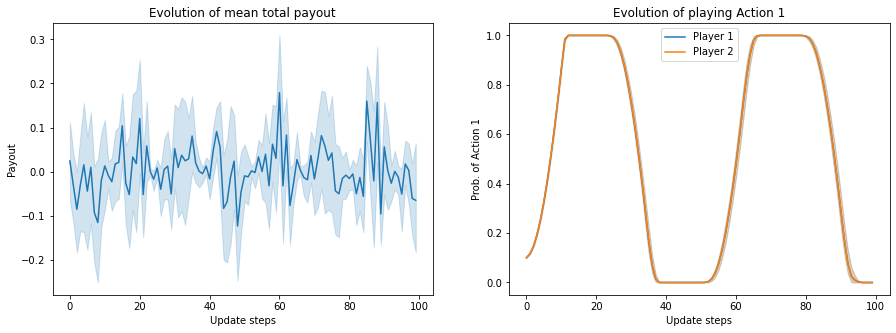

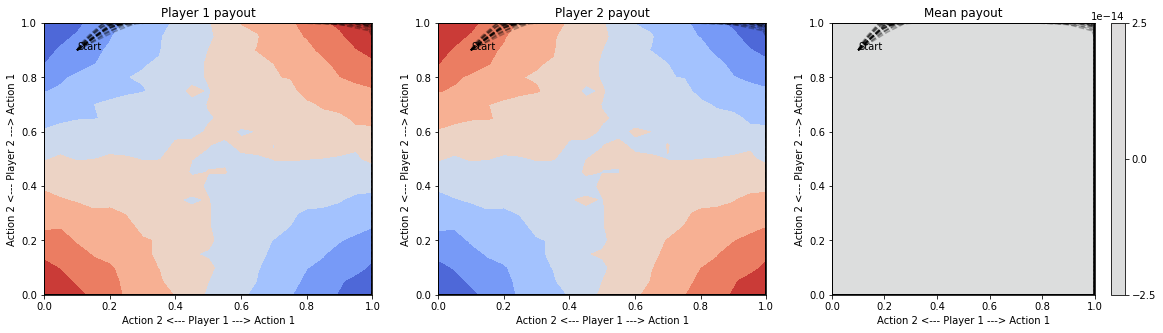

In [83]:
game_name = "Matching pennies"

run_experiment(PAYOFFS[game_name], 
                [0.1, 0.9], 
                num_updates=100,
                num_runs=20,
                game_name=game_name)

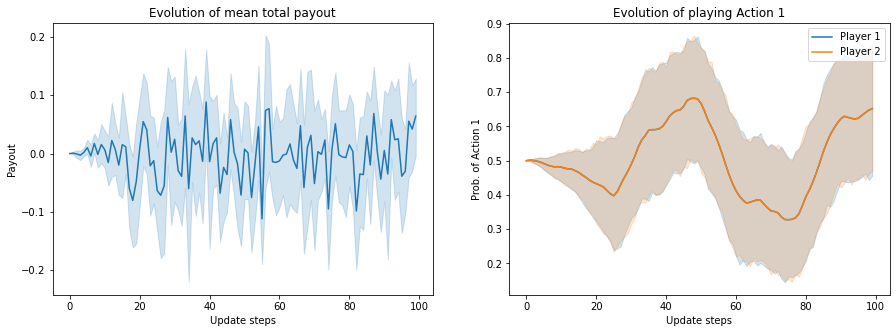

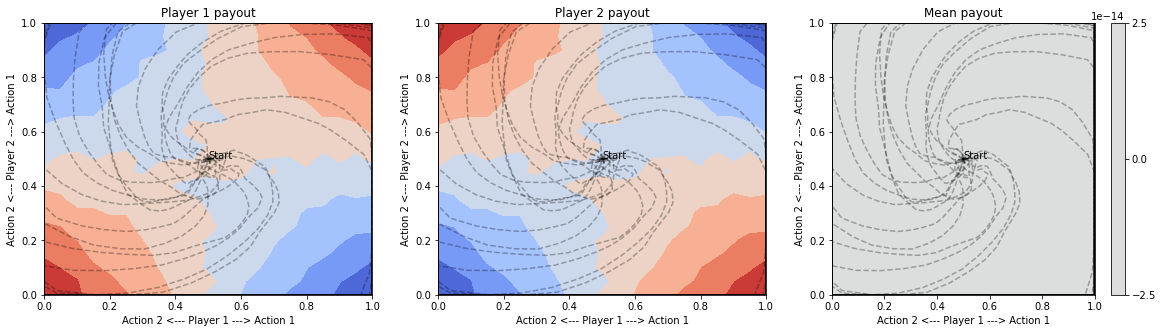

In [84]:
game_name = "Matching pennies"

run_experiment(PAYOFFS[game_name], 
                [0.5, 0.5], 
                num_updates=100,
                num_runs=20,
                game_name=game_name)

Bailey and Piliouras [[2018]](https://dl.acm.org/doi/10.1145/3219166.3219235)
showed that Nash equilibria are repelling which is apparent in the above diagram as well.

See also [Fast & Furious](https://papers.nips.cc/paper/2019/file/3501672ebc68a5524629080e3ef60aef-Paper.pdf).

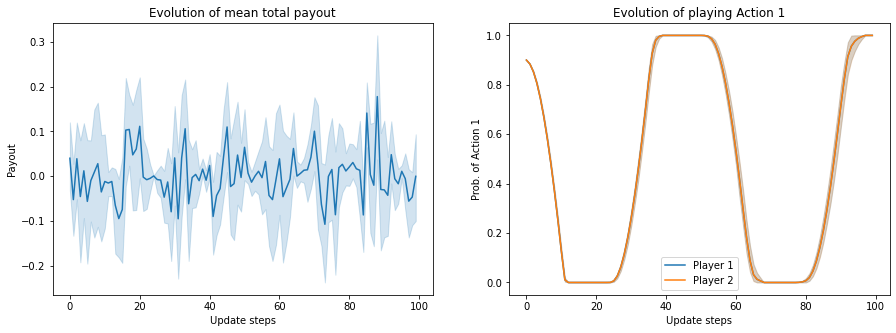

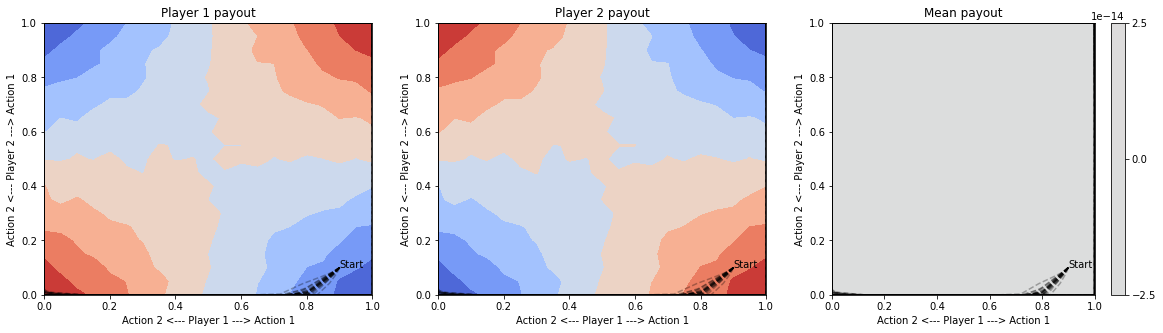

In [85]:
game_name = "Matching pennies"

run_experiment(PAYOFFS[game_name], 
                [0.9, 0.1], 
                num_updates=100,
                num_runs=20,
                game_name=game_name)

## Prisoner's dilemma 

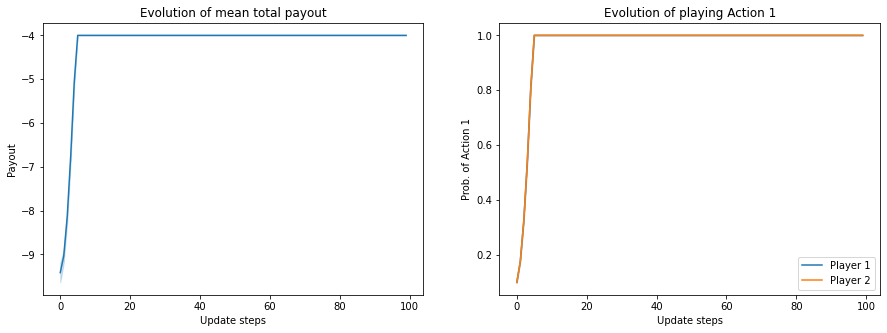

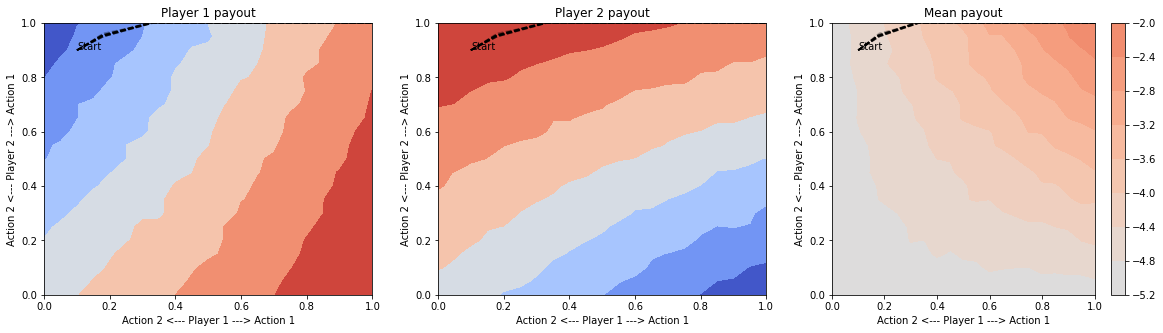

In [86]:
game_name = "Prisoner's dilemma"

run_experiment(PAYOFFS[game_name], 
                [0.1, 0.9], 
                num_updates=100,
                num_runs=20,
                game_name=game_name)

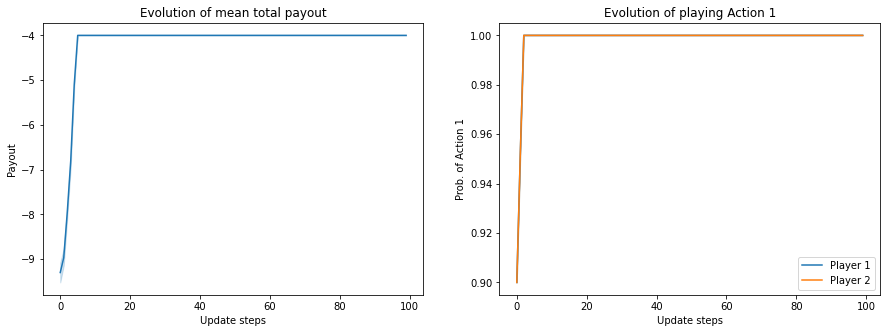

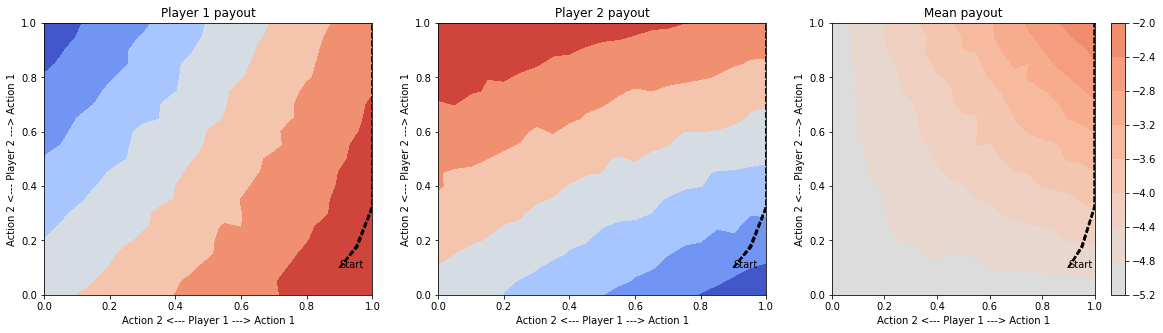

In [87]:
game_name = "Prisoner's dilemma"

run_experiment(PAYOFFS[game_name], 
                [0.9, 0.1], 
                num_updates=100,
                num_runs=20,
                game_name=game_name)

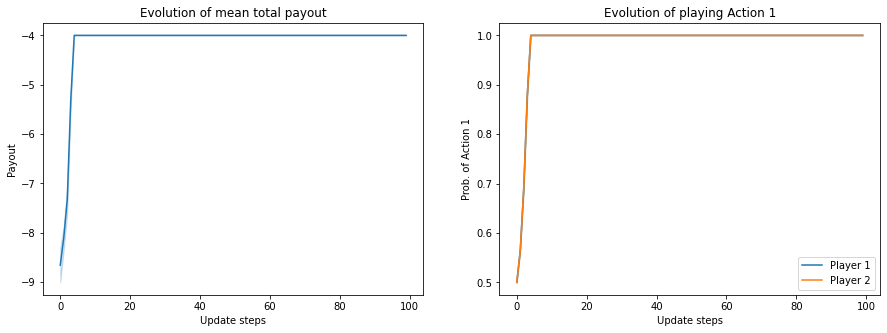

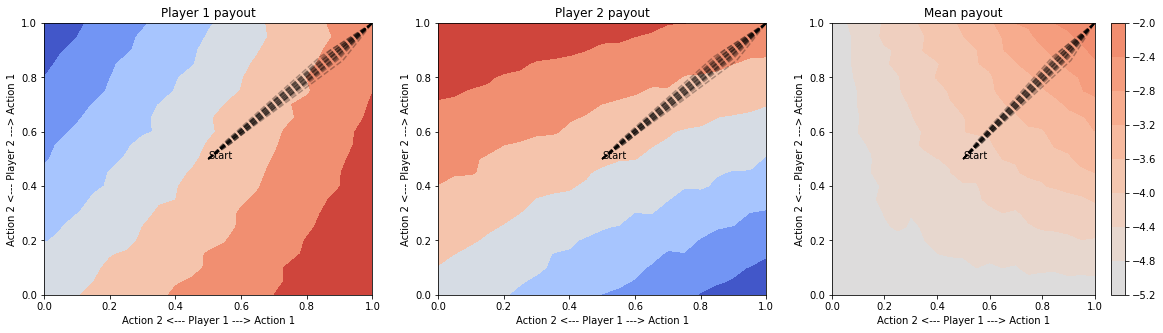

In [88]:
game_name = "Prisoner's dilemma"

run_experiment(PAYOFFS[game_name], 
                [0.5, 0.5], 
                num_updates=100,
                num_runs=20,
                game_name=game_name)

### Optimizing separately 

In [96]:
model = Model(PAYOFFS["Guess-the-same"])

p1_optimizer = SGD([model.strategies[0]], lr=0.001, momentum=0.9)
p2_optimizer = SGD([model.strategies[1]], lr=0.001, momentum=0.9)

num_updates = 20
rounds_per_update = 10
neg_payouts = np.empty(num_updates)
learned_strategies = np.empty((2, num_updates))

for i in range(num_updates):
    learned_strategies[:, i] = model.strategies.detach().numpy()[:, 0]
    
    # play the game and calculate the payout
    strategies = model.strategies.detach().numpy()
    plays, _ = play_mixing(strategies, payoff, rounds=rounds_per_update)
    neg_payout = model.negative_payout(plays)
    
    # gradient step
    neg_payout.backward()
    p1_optimizer.step()
    p2_optimizer.zero_grad()
    
    # normalize probabilities
    with torch.no_grad():
        model.strategies = nn.functional.softmax(model.strategies, dim=1)
    model.strategies.requires_grad = True
    
    neg_payouts[i] = neg_payout.detach().numpy()

ValueError: can't optimize a non-leaf Tensor

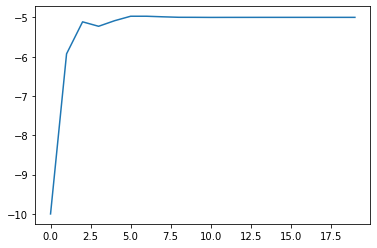

In [75]:
plt.figure()
plt.plot(range(num_updates), neg_payouts)
plt.show()

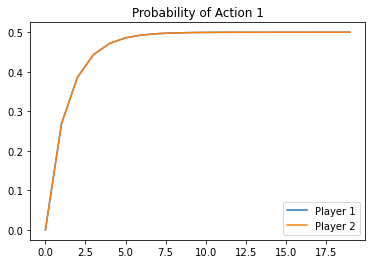

In [76]:
plt.figure()
plt.plot(range(num_updates), learned_strategies[0, :], label="Player 1")
plt.plot(range(num_updates), learned_strategies[1, :], label="Player 2")
plt.title("Probability of Action 1")
plt.legend()
plt.show()